In [1]:
import os
import sys

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler,QuantileTransformer

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import namedtuple

from IPython.display import clear_output

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
MDATA_PATH = '/home/chingisbadmaev/Desktop/sirius_university/machine_learning/mdata'
DEVICE = 'cpu'

full_name = 'Chingis Badmaev'
random_state = sum(map(ord,full_name))

In [4]:
def get_dates():
    return sorted(os.listdir(MDATA_PATH))

def get_tickers(date):
    return sorted(os.listdir(os.path.join(MDATA_PATH,date)))

dates = get_dates()

date_tickers = dict([(date,get_tickers(date)) for date in dates])
tickers = np.unique(np.concatenate(list(date_tickers.values()))).tolist()

def get_market_data(ticker):
    data = []
    for date in dates:
        if not os.path.exists(os.path.join(MDATA_PATH,date,ticker)):
            continue
        df = pd.read_csv(
            os.path.join(MDATA_PATH,date,ticker),
            compression='gzip',
            dtype={'bar_time':float,'TIMESTAMP':float},
            index_col=0,
            parse_dates=[2,3],
            date_parser=pd.to_datetime,
        )
        df.drop([
                'TIMESTAMP','WEEKDAY','MINUTE','HOUR','ZERO_SPREAD_ON_TRADE','EMPTY_LOB_SIDE_AFTER_UPDATE','NEGATIVE_SPREAD_AFTER_UPDATE',
                'ZERO_SPREAD_AFTER_UPDATE','EMPTY_LOB_SIDE_ON_TRADE','NEGATIVE_SPREAD_ON_TRADE','bar_count','BAR_DURATION'
            ], axis = 1, inplace = True
        )
        df = df[df.columns[~df.columns.str.startswith('EXEC')]]
        data.append(df)
    data = pd.concat(data).set_index('bar_time').sort_index()
    
    price_grid = data.filter(like='PRICE_GRID')
    vol_grid = data.filter(like='VOL_GRID')
    
    data = data[ data.columns[ ~data.columns.str.startswith('PRICE_GRID') & ~data.columns.str.startswith('VOL_GRID') ] ]
    
    return data,price_grid,vol_grid

In [5]:
ticker = 'Z.BNB'

In [6]:
mdata,pgrid,vgrid = get_market_data(ticker)
ix = (mdata['HIGH']<=1.1*mdata['VWAP'])&(mdata['LOW']>=0.9*mdata['VWAP'])
mdata,pgrid,vgrid = mdata[ix],pgrid[ix],vgrid[ix]
mdata = mdata.groupby(mdata.index).last()

In [7]:
returns_ahead = mdata['LAST'].pct_change().shift(-1).fillna(0)

# EXCLUDING NON-STATIONARY DATA HARD-CODED.
mdata.drop(['BEST_BID','BEST_ASK','LAST','HIGH','LOW','VWAP'],axis=1,inplace=True)

<Axes: >

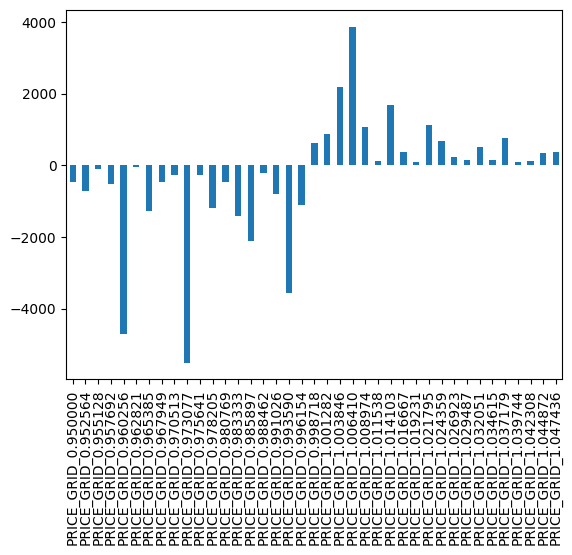

In [8]:
pgrid.iloc[0].plot(kind='bar')

<Axes: >

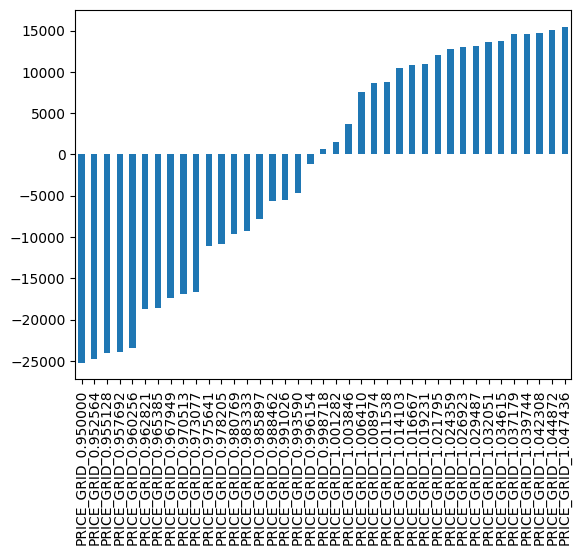

In [9]:
pd.concat([pgrid.iloc[0].iloc[:19][::-1].cumsum()[::-1],pgrid.iloc[0].iloc[19:].cumsum()]).plot(kind='bar')

looks pretty much as a picture, so we can use convolution networks to recognize patterns

In [10]:
# THIS IS DEBUG SELL TO CHECK DIMENSIONS

P_t = torch.tensor(pgrid.values,dtype=torch.float32,device=DEVICE)[:,None,:]
V_t = torch.tensor(vgrid.values,dtype=torch.float32,device=DEVICE)[:,None,:]

print (P_t.shape)
print (V_t.shape)

torch.Size([463470, 1, 39])
torch.Size([463470, 1, 18])


In [11]:
# TRAIN/VAL/TEST SPLIT

os_index_start = int(0.8*mdata.shape[0])

P_trainval,P_test = pgrid.iloc[:os_index_start].values,pgrid.iloc[os_index_start:].values
V_trainval,V_test = vgrid.iloc[:os_index_start].values,vgrid.iloc[os_index_start:].values
r_trainval,r_test = returns_ahead.iloc[:os_index_start].values,returns_ahead.iloc[os_index_start:].values

# within the train set split to real-train and validation sets
P_train,P_val,V_train,V_val,r_train,r_val = train_test_split(P_trainval,V_trainval,r_trainval,test_size=0.2,random_state=random_state)

In [12]:
# COLUMN TRANSFORMATIONS

# price grid
pct = QuantileTransformer()
pct.fit(P_train)
P_train_ct,P_val_ct,P_test_ct = pct.transform(P_train),pct.transform(P_val),pct.transform(P_test)

# vol grid
vct = QuantileTransformer()
vct.fit(V_train)
V_train_ct,V_val_ct,V_test_ct = vct.transform(V_train),vct.transform(V_val),vct.transform(V_test)

rct = QuantileTransformer()
rct.fit(r_train.reshape((r_train.size,1)))
r_train_ct,r_val_ct,r_test_ct = rct.transform(r_train.reshape((r_train.size,1))).flatten(),rct.transform(r_val.reshape((r_val.size,1))).flatten(),rct.transform(r_test.reshape((r_test.size,1))).flatten()

In [13]:
# TRANSFORM TO TENSORS

P_train_ct_t = torch.tensor(P_train_ct,dtype=torch.float32,device=DEVICE)
V_train_ct_t = torch.tensor(V_train_ct,dtype=torch.float32,device=DEVICE)
r_train_ct_t = torch.tensor(r_train_ct,dtype=torch.float32,device=DEVICE)

P_val_ct_t = torch.tensor(P_val_ct,dtype=torch.float32,device=DEVICE)
V_val_ct_t = torch.tensor(V_val_ct,dtype=torch.float32,device=DEVICE)
r_val_ct_t = torch.tensor(r_val_ct,dtype=torch.float32,device=DEVICE)

P_test_ct_t = torch.tensor(P_test_ct,dtype=torch.float32,device=DEVICE)
V_test_ct_t = torch.tensor(V_test_ct,dtype=torch.float32,device=DEVICE)
r_test_ct_t = torch.tensor(r_test_ct,dtype=torch.float32,device=DEVICE)

In [14]:
# HERE IS EXAMPLE IMPLEMENTATION OF PGRID NETWORK, WHICH WILL BE LATER A LAYER OF YOUR IMPLEMENTED CNN
# input_size = 39, output_size = 4

class MMFCNNPGrid(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pgrid = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=2,kernel_size=12,stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=2,out_channels=3,kernel_size=11,stride=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=3,out_channels=4,kernel_size=9,stride=1),
            nn.ReLU(),
            nn.Flatten(start_dim=1,end_dim=2),
            nn.ReLU()
        )
        
    def forward(self,x):
        out = self.pgrid.forward(x)
        return out

# just to make sure it delivers output of dimension = 4
mmf_cnn_pgrid = MMFCNNPGrid()
mmf_cnn_pgrid(P_train_ct_t[:,None,:]).shape

torch.Size([212080, 4])

In [15]:
# HERE IS EXAMPLE IMPLEMENTATION OF VGRID NETWORK, WHICH WILL BE LATER A LAYER OF YOUR IMPLEMENTED CNN
# assumed input_size = 18, output_size = 2

class MMFCNNVGrid(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.vgrid = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=2,kernel_size=6,stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=2,out_channels=2,kernel_size=5,stride=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=2,out_channels=2,kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Flatten(start_dim=1,end_dim=2),
            nn.ReLU()
        )
        
    def forward(self,x):
        out = self.vgrid.forward(x)
        return out

# just to make sure it delivers output of dimension = 2
mmf_cnn_vgrid = MMFCNNVGrid()
mmf_cnn_vgrid(V_train_ct_t[:,None,:]).shape

torch.Size([212080, 2])

In [16]:
mmf_cnn_vgrid(V_train_ct_t[:,None,:]).shape

torch.Size([212080, 2])

In [17]:
"""
ARCHITECTURE OF THE NETWORK TO BE IMPLEMENTED:

                    => Conv[channels:1->2,kernel=12,stride=1] => ReLU =>
                    => Conv[channels:2->3,kernel=11,stride=2] => ReLU =>
[pgrid layer]       => Conv[channels:3->4,kernel=9,stride=1] => ReLU =>
                    => Flatten on {1,2} => ReLU
                  /                                                      \
Features,dim=39+18                                                        => concatenation => Linear[features:6->1] => Flatten on {0,1} => ReLU
                  \                                                      /
                    => Conv[channels:1->2,kernel=6,stride=1] => ReLU =>
[vgrid layer]       => Conv[channels:2->2,kernel=5,stride=2] => ReLU =>
                    => Conv[channels:2->2,kernel=4,stride=2] => ReLU =>
                    => Flatten on {1,2} => ReLU
"""

class MMFCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.pgrid = nn.Sequential(
          nn.Conv1d(in_channels=1,out_channels=2,kernel_size=12,stride=1),
          nn.ReLU(),
          nn.Conv1d(in_channels=2,out_channels=3,kernel_size=11,stride=2),
          nn.ReLU(),
          nn.Conv1d(in_channels=3,out_channels=4,kernel_size=9,stride=1),
          nn.ReLU(),
          nn.Flatten(start_dim=1,end_dim=2),
          nn.ReLU()
        )

        self.vgrid = nn.Sequential(
          nn.Conv1d(in_channels=1,out_channels=2,kernel_size=6,stride=1),
          nn.ReLU(),
          nn.Conv1d(in_channels=2,out_channels=2,kernel_size=5,stride=2),
          nn.ReLU(),
          nn.Conv1d(in_channels=2,out_channels=2,kernel_size=4,stride=2),
          nn.ReLU(),
          nn.Flatten(start_dim=1,end_dim=2),
          nn.ReLU()
        )

        self.lin1 = nn.Linear(in_features=6,out_features=1)
        self.fl = nn.Flatten(start_dim=0,end_dim=1)
        self.relu = nn.ReLU()
    
    def forward(self,p,v):
        p = self.pgrid.forward(p)
        v = self.vgrid.forward(v)
        out = torch.concatenate([p, v], dim=1)
        out = self.lin1(out)
        out = self.fl(out)
        out = self.relu(out)
        return out


In [18]:
# MMFItem and MMFSet

MMFItem = namedtuple('MMFItem',['p','v','r'])

class MMFSet(torch.utils.data.Dataset):
    def __init__(self,P,V,r):
        super().__init__()
        
        assert P.shape[0] == r.shape[0] and V.shape[0] == r.shape[0]
        
        self.n_ticks = r.shape[0]
        self.p_t = torch.tensor(P,dtype=torch.float32,device=DEVICE)
        self.v_t = torch.tensor(V,dtype=torch.float32,device=DEVICE)
        self.r_t = torch.tensor(r,dtype=torch.float32,device=DEVICE)
    
    def __len__(self):
        return self.n_ticks
    
    def __getitem__(self,i):
        return MMFItem(
            p = self.p_t[i],
            v = self.v_t[i],
            r = self.r_t[i],
        )

In [19]:
# mmf_batch_index -> i
# 

In [20]:
BATCH_SIZE = 128

# объявляем сеть
mmf_cnn = MMFCNN()

# выбираем функцию потерь 
mmf_loss_fn = F.mse_loss

# выбираем алгоритм оптимизации и learning_rate
LEARNING_RATE = 1e-4
mmf_optimizer = torch.optim.Adam(mmf_cnn.parameters(),lr=LEARNING_RATE)

mmf_train_set = MMFSet(P_train_ct,V_train_ct,r_train_ct)
mmf_val_set = MMFSet(P_val_ct,V_val_ct,r_val_ct)

train_loss_hist = []
val_loss_hist = []
weights = []

for epoch in tqdm(range(25)):
    mmf_train_batch_set = torch.utils.data.DataLoader(
        mmf_train_set,
        batch_size = BATCH_SIZE,
        shuffle = False,
    )
    
    for i, mmf_batch in enumerate(mmf_train_batch_set):
        # получаем текущий батч
        X_p_batch = mmf_batch.p[:,None,:]
        X_v_batch = mmf_batch.v[:,None,:]
        X_r_batch = mmf_batch.r

        # forward + backward + optimize
        y_pred = mmf_cnn(X_p_batch.to(DEVICE), X_v_batch.to(DEVICE))

        loss = mmf_loss_fn(y_pred, X_r_batch.to(DEVICE))
        loss.backward()
        mmf_optimizer.step()

        # обнуляем веса
        mmf_optimizer.zero_grad()

    train_loss_hist.append(loss.item())
    weights.append(mmf_cnn.lin1.weight)


    # считаем ошибку на validation
    mmf_val_batch_set = torch.utils.data.DataLoader(
        mmf_val_set,
        batch_size = BATCH_SIZE,
        shuffle = False,
    )

    for i, mmf_batch in enumerate(mmf_val_batch_set):
        # получаем текущий батч
        X_p_batch = mmf_batch.p[:,None,:]
        X_v_batch = mmf_batch.v[:,None,:]
        X_r_batch = mmf_batch.r

        y_pred = mmf_cnn(X_p_batch.to(DEVICE), X_v_batch.to(DEVICE))

        loss = mmf_loss_fn(y_pred, X_r_batch.to(DEVICE))
    val_loss_hist.append(loss.item())
        
        
    tlh = pd.Series(train_loss_hist)
    vlh = pd.Series(val_loss_hist)


100%|██████████| 25/25 [04:59<00:00, 11.99s/it]


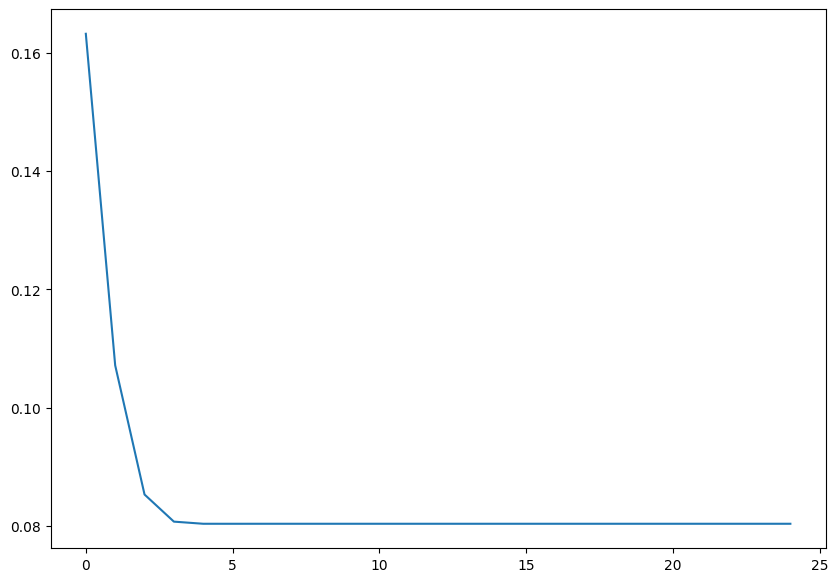

In [21]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

ax.clear()
ax.plot(np.arange(len(tlh)), tlh)
plt.show()

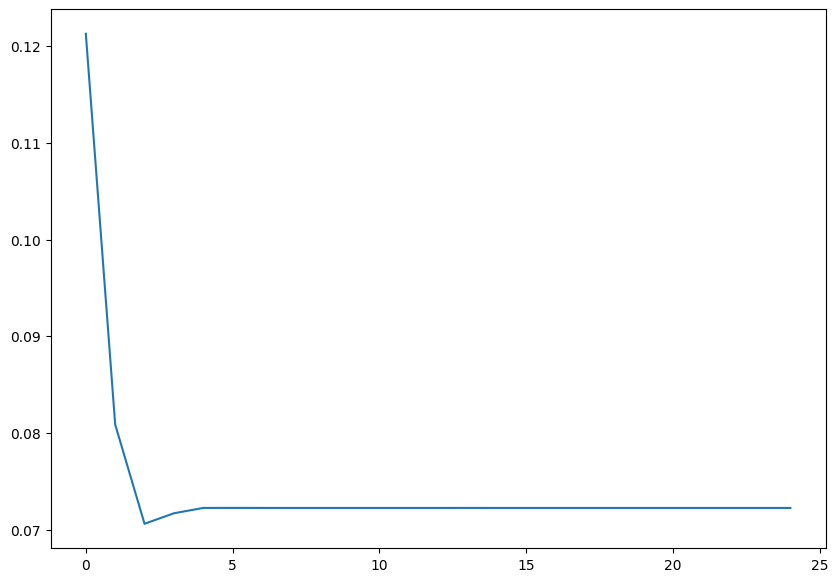

In [22]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

ax.clear()
ax.plot(np.arange(len(vlh)), vlh)
plt.show()

In [23]:
# TEST SET RESULTS

test_loss_hist = []

mmf_test_set = MMFSet(P_val_ct, V_val_ct, r_val_ct)

mmf_test_batch_set = torch.utils.data.DataLoader(
    mmf_test_set,
    batch_size = BATCH_SIZE,
    shuffle = False,
)

for i, mmf_batch in enumerate(mmf_test_batch_set):
    # получаем текущий батч
    X_p_batch = mmf_batch.p[:,None,:]
    X_v_batch = mmf_batch.v[:,None,:]
    X_r_batch = mmf_batch.r

    y_pred = mmf_cnn(X_p_batch.to(DEVICE), X_v_batch.to(DEVICE))

    loss = mmf_loss_fn(y_pred, X_r_batch.to(DEVICE))
    test_loss_hist.append(loss.item())

средняя ошибка для одного batch 0.08334546342312571
средняя ошибка для одного наблюдения 0.0006511364329931696


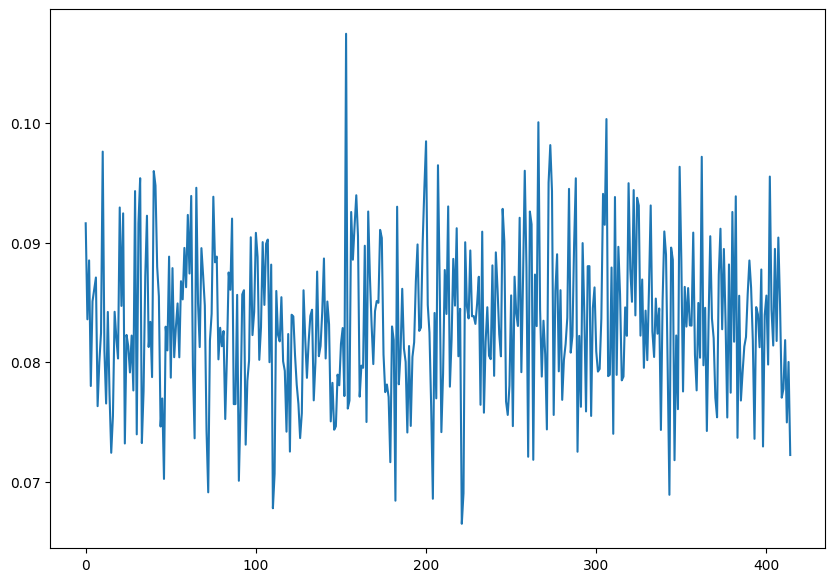

In [24]:
print('средняя ошибка для одного batch', np.mean(test_loss_hist))
print('средняя ошибка для одного наблюдения', np.mean(test_loss_hist) / BATCH_SIZE)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

ax.clear()
ax.plot(np.arange(len(test_loss_hist)), test_loss_hist)
plt.show()

In [25]:
weights

[Parameter containing:
 tensor([[-0.0769, -0.4512, -0.0847, -0.2370, -0.2107, -0.4003]],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0769, -0.4512, -0.0847, -0.2370, -0.2107, -0.4003]],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0769, -0.4512, -0.0847, -0.2370, -0.2107, -0.4003]],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0769, -0.4512, -0.0847, -0.2370, -0.2107, -0.4003]],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0769, -0.4512, -0.0847, -0.2370, -0.2107, -0.4003]],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0769, -0.4512, -0.0847, -0.2370, -0.2107, -0.4003]],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0769, -0.4512, -0.0847, -0.2370, -0.2107, -0.4003]],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0769, -0.4512, -0.0847, -0.2370, -0.2107, -0.4003]],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0769, -0.4512, -0.08